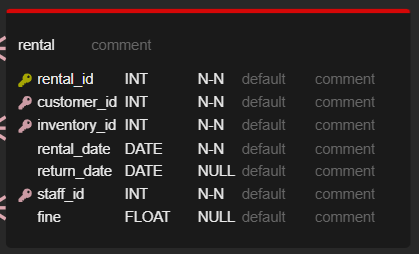

In [2]:
import pandas as pd
import numpy as np
import datetime
import random
from dateutil.relativedelta import relativedelta

In [6]:
#czas wypozyczenia to 1 tydzień, 1 dzien opoznienia to 1/10 ceny wypozyczenia
#zakladamy okolo 35 wypozyczen dziennie co daje lacznie okolo 19 tysiecy (powiedzmyze 19241)

In [7]:
inventory_rent = pd.read_csv('inventory_rent.csv')
customer = pd.read_csv('customers.csv')
games = pd.read_csv('games.csv')

In [11]:
np.random.seed(42)

In [12]:
#warunki
    # 1. osoba moze wypozyczyc gre adekwatną do swojego wieku
    # 2. nie mozna wypozyczyc gry ktora nie zostala jeszcze oddana
    # 3. return date bedzie pomiedzy rental_date a rental_date + tydzien z pr np 0.7 a rental_date + tdyzien + np 5 dni z pr 0.3
    # 4. staff_id - jesli rental_date to niedziela to staff_id to 1
    # 5. dla vipow mamy 10% znizki od ceny wypozyczenia
    # 6. osoba moze wypozyczyc gre po terminie zarejestrowania sie w sklepie
    # 7. w swieta sklep zamykamy
    # 8. kazdy dzien spoznienia w oddaniu (max tydzien) to + 1/10 ceny wypozyczenia

In [13]:
def days_from_last_rent(date):
    diff_date = (date - datetime.date(2021, 1, 4)).days
    x = 0.6 / (1+np.e**(-0.01005*(diff_date-300)))
    possible_days = [0, np.random.randint(1,9), np.random.randint(10,21), np.random.randint(22,41), 
                     np.random.randint(42, 120)]
    prob = [0.02, x, 0.75-3*x/4, 0.22-x/4, 0.01]
    
    return int(np.random.choice(possible_days, p = prob))

In [14]:
# 0 bo moga przyjsc pograc na miejscu i od razu oddac
def rent_days():
    possible_days = [0, np.random.randint(1,8), np.random.randint(8,14), np.random.randint(15,31),
                     np.random.randint(31, 61), np.random.randint(61, 121), np.random.randint(121, 672)]
    prob = [0.2, 0.5, 0.2, 0.05, 0.03, 0.017, 0.003]
    return int(np.random.choice(possible_days, p = prob))

In [15]:
inventory_id = inventory_rent['inventory_id']

In [16]:
def create_rental():
    rental = pd.DataFrame(columns = ['inventory_id', 'rental_date', 'return_date', 'game_id'])
    for i in inventory_id:
        return_date = datetime.date(2021, 1, 4)
        
        while return_date < datetime.date(2023, 6, 15):
            rental_date = return_date +  datetime.timedelta(days = days_from_last_rent(return_date))
            return_date = rental_date + datetime.timedelta(days = rent_days())
            if rental_date <= datetime.date(2023, 6, 15):
                if return_date > datetime.date(2023, 6, 15):
                    new_return_date = None
                    new_row = {'inventory_id' : i, 'rental_date' : rental_date, 'return_date' : new_return_date,
                               'game_id' : int(inventory_rent.loc[inventory_rent['inventory_id'] == i, 'game_id'].values)}
                    rental.loc[len(rental)] = new_row
                else:
                    new_row = {'inventory_id' : i, 'rental_date' : rental_date, 'return_date' : return_date,
                              'game_id' : int(inventory_rent.loc[inventory_rent['inventory_id'] == i, 'game_id'].values)}
                    rental.loc[len(rental)] = new_row
    return rental

In [17]:
rental = create_rental()

In [18]:
rental['rental_date'] = pd.to_datetime(rental['rental_date'])
rental['return_date'] = pd.to_datetime(rental['return_date'])
rental = rental.sort_values(by='rental_date')

In [19]:
n_id = len(rental)
n_id

20553

In [20]:
rental['rental_id'] = np.arange(1, n_id+1)
rental = rental.iloc[:,[4,0,1,2,3]]

## customer_id

In [22]:
#wiek = data wypozyczenia(rental) - data_urodzenia (customer)
#wiek >= PEGI od danego game id w tabeli games

In [23]:
#UWAGA!!!! długo mieli
cst_id = []
for i in range(0, len(rental)):
    cont = True
    while cont:
        customer_id = random.choice(np.arange(1, len(customer)+1)) 
        wiek = relativedelta(rental.iloc[i]['rental_date'], datetime.datetime.strptime(customer['birthdate'][customer_id-1], '%Y-%m-%d')).years
        if (wiek < games.loc[games['game_id'] == rental.iloc[i]['game_id'], 'age'].values or 
            customer['registration_date'][customer_id-1] > str(rental.iloc[i]['rental_date'].date())):
            continue
        else:
            cst_id.append(customer_id)
            break

In [25]:
rental['customer_id'] = cst_id

## staff_id

In [26]:
staff = pd.read_csv('staff.csv')
staff.head()

,Unnamed: 0,staff_id,first_name,last_name,salary,birth_date,start,phone,address_id,email
0,0,1,Tomasz,Stroiński,5000,1995-01-01,2021-01-04,923128647,1,t.stroinski@gamefinity.com
1,1,2,Wiktoria,Fimińska,3500,2001-02-02,2021-01-20,756837957,2,w.fiminska@gamefinity.com
2,2,3,Karolina,Wypych,3500,2001-09-03,2021-04-08,567938928,3,k.wypych@gamefinity.com
3,3,4,Julia,Grzegorzewska,3500,2001-09-03,2021-11-26,566552356,4,j.grzegorzewska@gamefinity.com
4,4,5,Mateusz,Stasiak,3500,2001-10-15,2022-02-07,666555827,5,m.stasiak@gamefinity.com


In [27]:
free_days = ['2023-01-01', '2023-01-06', '2023-04-09', '2023-04-10', '2023-05-01', '2023-05-03', '2023-05-28', '2023-06-08',
            '2022-01-01', '2022-01-06', '2022-04-17', '2022-04-18', '2022-05-01', '2022-05-03', '2022-06-05', '2022-06-16',
            '2022-08-15', '2022-11-01', '2022-11-11', '2022-12-25', '2022-12-26', '2021-01-06', '2021-04-04', '2021-04-05',
            '2021-05-01', '2021-05-03', '2021-05-23', '2021-06-03', '2021-08-15', '2021-11-01', '2021-11-11', '2021-12-25',
            '2021-12-26']

In [28]:
# nie uwzglednia tego ze tego samego dnia ten sam pracownik (do ustalenia czy tak robimy)
staff_id = []
for i in range(0, len(rental)):
    if (rental.iloc[i]['rental_date'].weekday() == 6 or 
        rental.iloc[i]['rental_date'] < datetime.datetime(2021, 1, 20) or 
        str(rental.iloc[i]['rental_date'].date()) in free_days):
        staff_id.append(1)
    elif rental.iloc[i]['rental_date'] >= datetime.datetime(2022, 2, 7):
        staff_id.append(random.choice([1,2,3,4,5]))
    elif datetime.datetime(2022, 2, 7) > rental.iloc[i]['rental_date'] >= datetime.datetime(2021, 11, 26):
        staff_id.append(random.choice([1,2,3,4]))
    elif datetime.datetime(2021, 11, 26) > rental.iloc[i]['rental_date'] >= datetime.datetime(2021, 4, 8):
        staff_id.append(random.choice([1,2,3]))
    elif datetime.datetime(2021, 4, 8) > rental.iloc[i]['rental_date'] >= datetime.datetime(2021, 1, 20):
        staff_id.append(random.choice([1,2]))

In [29]:
rental['staff_id'] = staff_id

In [31]:
rental.to_csv('rental.csv')

## price

In [32]:
#!!!to dopiero wywoływać po przeladowaniu customers od nowa !!!

In [33]:
#jak vip to 10% znizki
#cena wypozyczenia to normalna cena + 10% znizki jesli vip + kara za opoznienei w oddaniu (kara w osobnej kolumnie)

In [34]:
games_buy_prices = {
    '1': 164.5,
    '2' : 65.00,
    '3' : 158.70,
    '4' : 170.32,
    '5' : 139.90,
    '6' : 119.19,
    '7' : 182.55,
    '8' : 179.90,
    '9': 409.95,
    '10' : 269.90,
    '11' : 59.90,
    '12' : 169.90,
    '13' : 479.00,
    '14' : 169.00,
    '15' : 42.38,
    '16' : 100.00,
    '17' : 39.90,
    '18' : 62.50,
    '19' : 199.99,
    '20' : 112.89,
    '21': 650.00,
    '22' : 219.00,
    "23" : 25.50,
    '24' : 188.65, 
    '25' : 56.60,
    '26' : 350.00,
    '27' : 74.99,
    '28' : 129.99,
    '29' : 289.00,
    '30' : 277.80,
    '31' : 120.00,
    '32' : 115.60,
    '33' : 158.95,
    '34' : 28.00,
    '35' : 162.55,
    '36' : 185.2,
    '37' : 46.50,
    '38' : 239.90,
    '39' : 37.00,
    '40' : 103.00,
    '41' : 28.80,
    '42' : 120.00,
    '43' : 56.70,
    '44' : 79.90,
    '45' : 117.97,
    '46' : 25.60,
    '47' : 16.70,
    '48' : 180.00,
    '49' : 115.60,
    '50' : 133.20
}

In [35]:
divide_by = 15

In [36]:
games_rent_prices_dict = {game_id: round(buy_price/divide_by, 2) for game_id, buy_price in games_buy_prices.items()}

In [37]:
games_rent_prices = pd.DataFrame(games_rent_prices_dict.items(), columns=['game_id', 'rent_price'])
games_rent_prices

,game_id,rent_price
0,1,10.97
1,2,4.33
2,3,10.58
3,4,11.35
4,5,9.33
5,6,7.95
6,7,12.17
7,8,11.99
8,9,27.33
9,10,17.99


In [38]:
#jesli nie jest vipem (nan) albo jesli data wypozyczenia < vip to normalna cena

In [39]:
main_price = []
for i in range(0, len(rental)):
    if customer.loc[customer['customer_id'] == rental.iloc[i]['customer_id'], 'VIP'].values[0] is np.nan:
        main_price.append(games_rent_prices.loc[games_rent_prices['game_id'] == str(rental.iloc[i]['game_id']), 'rent_price'].values[0])
    elif customer.loc[customer['customer_id'] == rental.iloc[i]['customer_id'], 'VIP'].values[0] > str(rental.iloc[i]['rental_date'].date()):
        main_price.append(games_rent_prices.loc[games_rent_prices['game_id'] == str(rental.iloc[i]['game_id']), 'rent_price'].values[0])
    else:
        main_price.append(games_rent_prices.loc[games_rent_prices['game_id'] == str(rental.iloc[i]['game_id']), 'rent_price'].values[0] * 0.9)

In [40]:
rental['price'] = main_price

## fine

In [41]:
rental

,rental_id,inventory_id,rental_date,return_date,game_id,customer_id,staff_id,price
16184,1,390,2021-01-04,2021-01-12,13,34,1,31.930
8152,2,196,2021-01-04,2021-01-04,39,34,1,2.470
12329,3,298,2021-01-04,2021-01-13,35,34,1,10.840
1802,4,43,2021-01-04,2021-01-19,33,34,1,10.600
9642,5,233,2021-01-04,2021-01-09,5,34,1,9.330
...,...,...,...,...,...,...,...,...
7466,20549,178,2023-06-15,NaT,22,180,4,13.140
3851,20550,92,2023-06-15,NaT,1,187,4,9.873
8483,20551,203,2023-06-15,NaT,22,34,2,13.140
7506,20552,179,2023-06-15,2023-06-15,13,26,5,28.737


In [42]:
relativedelta(rental.iloc[0]['return_date'],rental.iloc[0]['rental_date'],  '%Y-%m-%d').days -7

1

In [45]:
pd.isnull(rental.iloc[len(rental)-1]['return_date']) #spr czy NaT

True

In [46]:
fine = []
for i in range(0, len(rental)):
    if pd.isnull(rental.iloc[i]['return_date']):
        fine.append(None)
    elif relativedelta(rental.iloc[i]['return_date'],rental.iloc[i]['rental_date'],  '%Y-%m-%d').days <= 7:
        fine.append(0)
    else:
        delay_days = relativedelta(rental.iloc[i]['return_date'],rental.iloc[i]['rental_date'],  '%Y-%m-%d').days - 7
        fine.append(round(delay_days * 0.1 * rental.iloc[i]['price'], 2))

In [47]:
rental['fine'] = fine

In [48]:
rental

,rental_id,inventory_id,rental_date,return_date,game_id,customer_id,staff_id,price,fine
16184,1,390,2021-01-04,2021-01-12,13,34,1,31.930,3.19
8152,2,196,2021-01-04,2021-01-04,39,34,1,2.470,0.00
12329,3,298,2021-01-04,2021-01-13,35,34,1,10.840,2.17
1802,4,43,2021-01-04,2021-01-19,33,34,1,10.600,8.48
9642,5,233,2021-01-04,2021-01-09,5,34,1,9.330,0.00
...,...,...,...,...,...,...,...,...,...
7466,20549,178,2023-06-15,NaT,22,180,4,13.140,NaN
3851,20550,92,2023-06-15,NaT,1,187,4,9.873,NaN
8483,20551,203,2023-06-15,NaT,22,34,2,13.140,NaN
7506,20552,179,2023-06-15,2023-06-15,13,26,5,28.737,0.00


In [50]:
rental.to_csv('rental.csv')